In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install --upgrade keras
!pip install tensorflow
!pip install keras_facenet
!pip install mtcnn

  Using cached keras-3.0.5-py3-none-any.whl (1.0 MB)
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.0.5 which is incompatible.
  Using cached keras-2.15.0-py3-none-any.whl (1.7 MB)
  Attempting uninstall: keras
    Found existing installation: keras 3.0.5
    Uninstalling keras-3.0.5:
      Successfully uninstalled keras-3.0.5


In [3]:
import cv2 as cv
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [4]:
print(os.listdir("/content/drive/MyDrive/Facial_Recognition/dataset"))

['Omer', 'Murtaza', 'Arbaz']


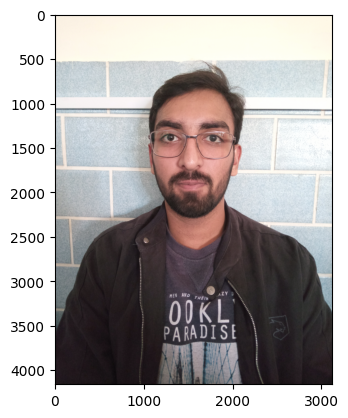

In [5]:
img = cv.imread("/content/drive/MyDrive/Facial_Recognition/dataset/Omer/omer.jpg")
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt.imshow(img)


# Libs Installed

In [6]:
from mtcnn.mtcnn import MTCNN

detector = MTCNN()
results = detector.detect_faces(img)

1/1 [==============================] - 0s 347ms/step


In [7]:
results


[{'box': [1037, 817, 996, 1417],
  'confidence': 0.9999995827674866,
  'keypoints': {'left_eye': (1294, 1384),
   'right_eye': (1774, 1397),
   'nose': (1524, 1669),
   'mouth_left': (1342, 1901),
   'mouth_right': (1706, 1908)}}]

In [8]:
x,y,w,h = results[0]['box']

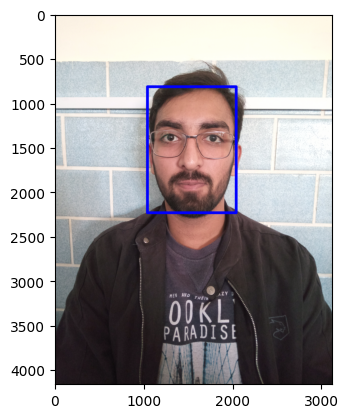

In [9]:
img = cv.rectangle(img, (x,y), (x+w, y+h), (0,0,255), 30)
plt.imshow(img)

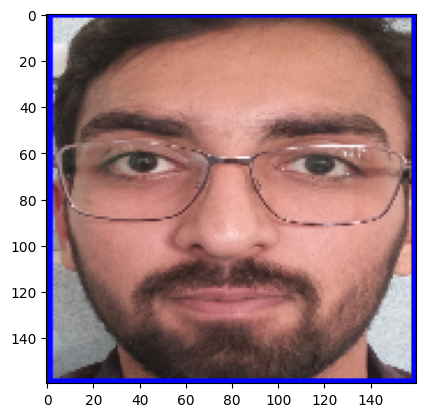

In [10]:
my_face = img[y:y+h, x:x+w]
#Facenet takes as input 160x160
my_face = cv.resize(my_face, (160,160))
plt.imshow(my_face)

In [11]:
class FACELOADING:
    def __init__(self, directory):
        self.directory = directory
        self.target_size = (160,160)
        self.X = []
        self.Y = []
        self.detector = MTCNN()


    def extract_face(self, filename):
        img = cv.imread(filename)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        x,y,w,h = self.detector.detect_faces(img)[0]['box']
        x,y = abs(x), abs(y)
        face = img[y:y+h, x:x+w]
        face_arr = cv.resize(face, self.target_size)
        return face_arr


    def load_faces(self, dir):
        FACES = []
        for im_name in os.listdir(dir):
            try:
                path = dir + im_name
                single_face = self.extract_face(path)
                FACES.append(single_face)
            except Exception as e:
                pass
        return FACES

    def load_classes(self):
        for sub_dir in os.listdir(self.directory):
            path = self.directory +'/'+ sub_dir+'/'
            FACES = self.load_faces(path)
            labels = [sub_dir for _ in range(len(FACES))]
            print(f"Loaded successfully: {len(labels)}")
            self.X.extend(FACES)
            self.Y.extend(labels)

        return np.asarray(self.X), np.asarray(self.Y)


    def plot_images(self):
        plt.figure(figsize=(18,16))
        for num,image in enumerate(self.X):
            ncols = 3
            nrows = len(self.Y)//ncols + 1
            plt.subplot(nrows,ncols,num+1)
            plt.imshow(image)
            plt.axis('off')

In [12]:
faceloading = FACELOADING("/content/drive/MyDrive/Facial_Recognition/dataset")
X, Y = faceloading.load_classes()

1/1 [==============================] - 0s 30ms/step
Loaded successfully: 11
1/1 [==============================] - 0s 32ms/step
Loaded successfully: 11
1/1 [==============================] - 0s 38ms/step
Loaded successfully: 11


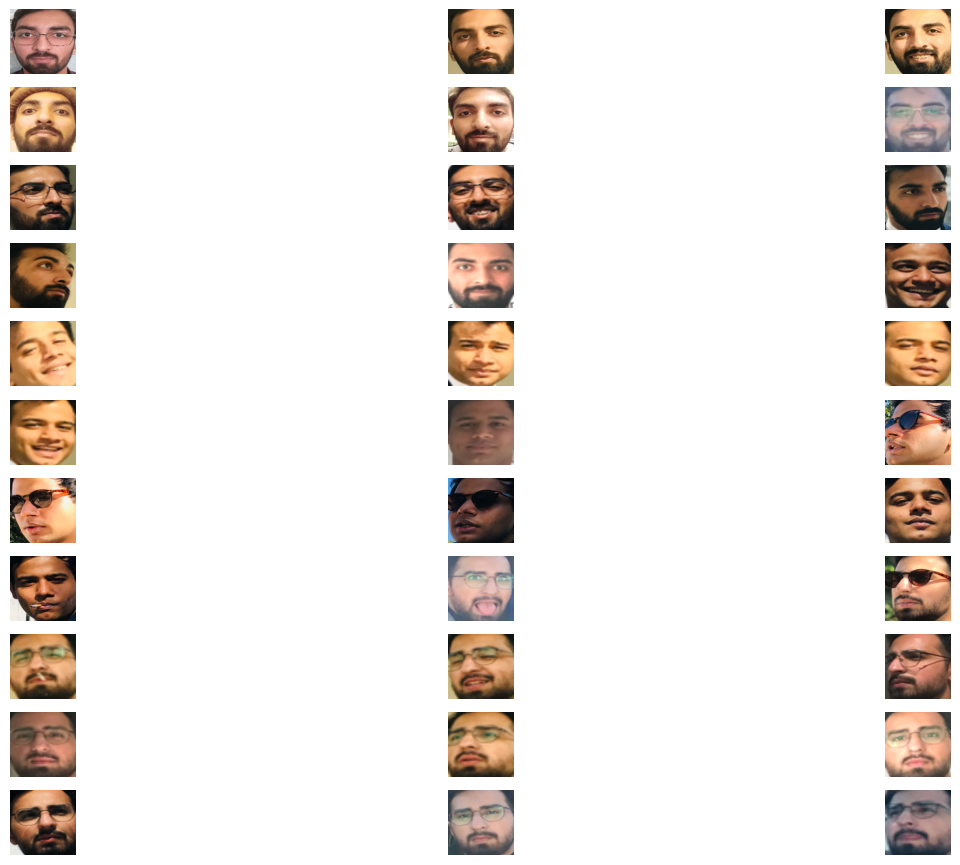

In [13]:

plt.figure(figsize=(16,12))
for num,image in enumerate(X):
    ncols = 3
    nrows = len(Y)//ncols + 1
    plt.subplot(nrows,ncols,num+1)
    plt.imshow(image)
    plt.axis('off')

In [14]:

!pip install keras-facenet

In [15]:
from keras_facenet import FaceNet
embedder = FaceNet()

def get_embedding(face_img):
    face_img = face_img.astype('float32') # 3D(160x160x3)
    face_img = np.expand_dims(face_img, axis=0)
    # 4D (Nonex160x160x3)
    yhat= embedder.embeddings(face_img)
    return yhat[0] # 512D image (1x1x512)

In [16]:
EMBEDDED_X = []

for img in X:
    EMBEDDED_X.append(get_embedding(img))

EMBEDDED_X = np.asarray(EMBEDDED_X)

1/1 [==============================] - 0s 124ms/step


In [17]:
np.savez_compressed('faces_embeddings_done_4classes.npz', EMBEDDED_X, Y)

In [18]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(Y)
Y = encoder.transform(Y)

Text(0, 0.5, '2')

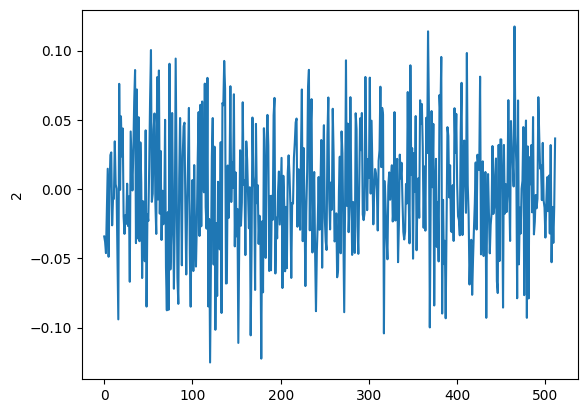

In [19]:
plt.plot(EMBEDDED_X[0])
plt.ylabel(Y[0])

In [20]:
break

SyntaxError: 'break' outside loop (<ipython-input-20-6aaf1f276005>, line 1)

In [21]:
Y

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(EMBEDDED_X, Y, shuffle=True, random_state=17)

In [23]:
from sklearn.svm import SVC
model = SVC(kernel='linear', probability=True)
model.fit(X_train, Y_train)

SVC(kernel='linear', probability=True)

In [24]:
ypreds_train = model.predict(X_train)
ypreds_test = model.predict(X_test)

In [25]:
from sklearn.metrics import accuracy_score

accuracy_score(Y_train, ypreds_train)



1.0

/content/drive/MyDrive/Facial_Recognition/Test/Omer/omer_test.jpg
1/1 [==============================] - 0s 99ms/step
/content/drive/MyDrive/Facial_Recognition/Test/Omer/Screenshot 2024-02-29 000412.png
1/1 [==============================] - 0s 135ms/step
/content/drive/MyDrive/Facial_Recognition/Test/Omer/Screenshot 2024-02-29 000546.png
1/1 [==============================] - 0s 96ms/step
/content/drive/MyDrive/Facial_Recognition/Test/Omer/IMG_4391.jpg
1/1 [==============================] - 0s 156ms/step
/content/drive/MyDrive/Facial_Recognition/Test/Omer/Screenshot 2024-02-29 000455.png
1/1 [==============================] - 0s 154ms/step
/content/drive/MyDrive/Facial_Recognition/Test/Omer/IMG_20230629_090554_288.jpg
1/1 [==============================] - 0s 95ms/step
/content/drive/MyDrive/Facial_Recognition/Test/Murtaza/Screenshot 2024-02-29 000709.png
1/1 [==============================] - 0s 94ms/step
/content/drive/MyDrive/Facial_Recognition/Test/Murtaza/Screenshot 2024-02-29 00

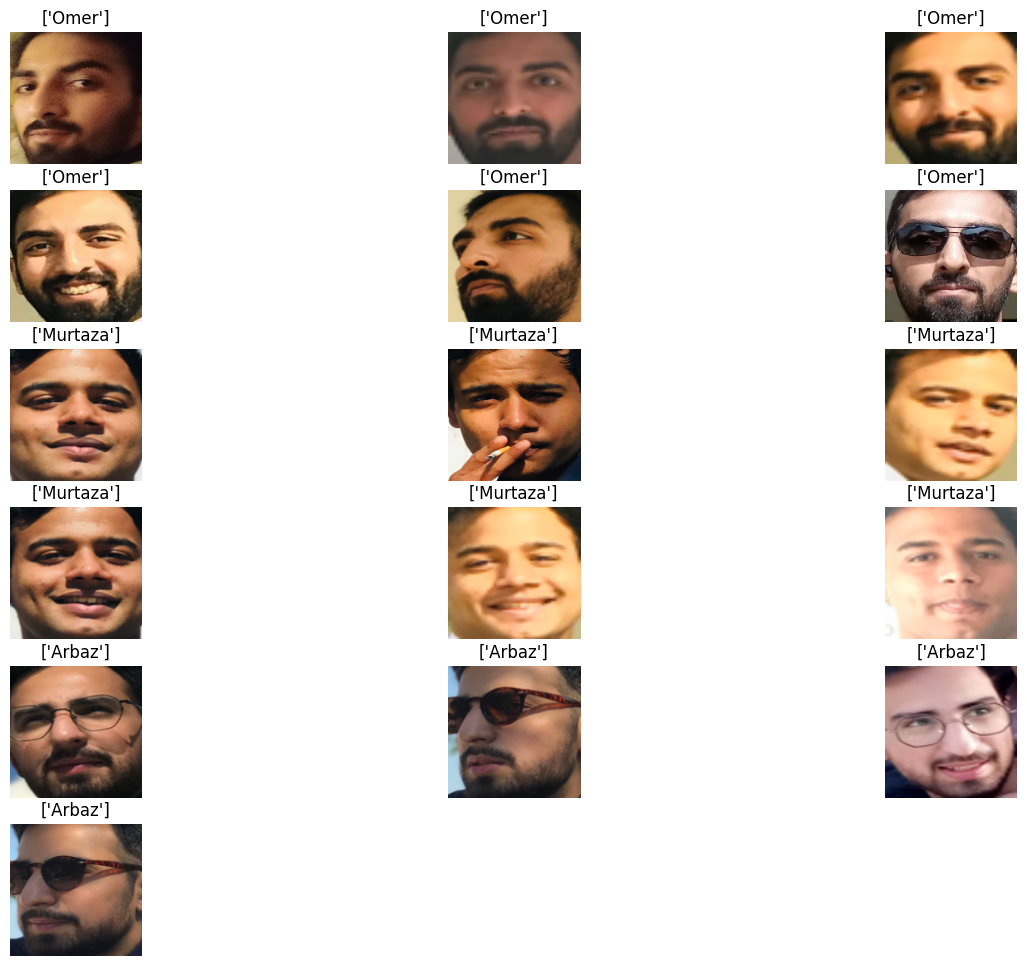

In [29]:
import os
import cv2 as cv
import matplotlib.pyplot as plt

def get_image_paths(directory_path):
    images = []
    labels = []

    # Iterate through each subdirectory in the given directory
    for root, dirs, files in os.walk(directory_path):
        # Check if the current directory contains image files
        for file in files:
            if file.lower().endswith(('.jpg', '.png')):
                # Construct the full path to the image file
                image_path = os.path.join(root, file)
                print(image_path)
                # Load and process the image
                t_im = cv.imread(image_path)
                t_im = cv.cvtColor(t_im, cv.COLOR_BGR2RGB)
                x,y,w,h = detector.detect_faces(t_im)[0]['box']
                t_im = t_im[y:y+h, x:x+w]
                t_im = cv.resize(t_im, (160,160))
                test_im = get_embedding(t_im)
                test_im = [test_im]
                ypreds = model.predict(test_im)

                images.append(t_im)
                labels.append(encoder.inverse_transform(ypreds))

    # Plot images with labels
    num_images = len(images)
    ncols = 3
    nrows = num_images // ncols + 1
    plt.figure(figsize=(16, 12))

    for idx, (image, label) in enumerate(zip(images, labels), 1):
        plt.subplot(nrows, ncols, idx)
        plt.imshow(image)
        plt.title(label)
        plt.axis('off')

    # Save the plot to the Results folder
    result_path = os.path.join(directory_path, "final_image_with_labels.png")
    plt.savefig(result_path)
    plt.show()

get_image_paths("/content/drive/MyDrive/Facial_Recognition/Test")


1/1 [==============================] - 0s 35ms/step


KeyboardInterrupt: 

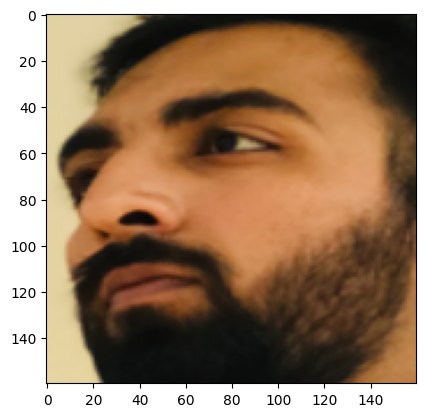

In [122]:
for each in paths:


In [94]:
ypreds



array([1])

# Thank you

array(['Murtaza'], dtype='<U7')

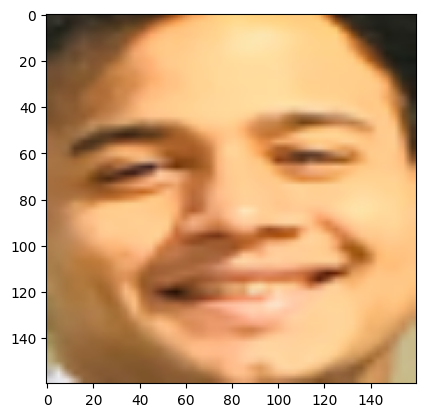

In [86]:
import pickle
#save the model
with open('svm_model_160x160.pkl','wb') as f:
    pickle.dump(model,f)